In [32]:
import os
import tarfile
import shutil
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import seaborn as sns

In [42]:
# Create all required directories
os.makedirs("raw_data", exist_ok=True)
os.makedirs("extracted", exist_ok=True)
os.makedirs("protocols", exist_ok=True)
os.makedirs("data/train/real", exist_ok=True)
os.makedirs("data/train/fake", exist_ok=True)
os.makedirs("data/dev/real", exist_ok=True)
os.makedirs("data/dev/fake", exist_ok=True)
os.makedirs("processed/train/real", exist_ok=True)
os.makedirs("processed/train/fake", exist_ok=True)
os.makedirs("processed/dev/real", exist_ok=True)
os.makedirs("processed/dev/fake", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("extracted/flac_T", exist_ok=True)
os.makedirs("extracted/flac_D", exist_ok=True)


print("Directory structure created successfully!")

Directory structure created successfully!


In [43]:
# ## Step 1: Verify Extracted Files

# %% [code]
def check_extracted_files(extracted_dir):
    """Count and list all .flac files in extracted directory"""
    flac_files = [f for f in os.listdir(extracted_dir) if f.endswith('.flac')]
    print(f"Found {len(flac_files)} .flac files in {extracted_dir}")
    return flac_files

# Check training and dev files
train_flacs = check_extracted_files("extracted/flac_T")
dev_flacs = check_extracted_files("extracted/flac_D")

Found 0 .flac files in extracted/flac_T
Found 0 .flac files in extracted/flac_D


In [46]:
!tar -xvf raw_data/flac_T_aa.tar -C extracted/
!tar -xvf raw_data/flac_D_aa.tar -C extracted/
!tar -xzf raw_data/ASVspoof5_protocols.tar.gz -C protocols/

x flac_T/T_0000000000.flac
x flac_T/T_0000000001.flac
x flac_T/T_0000000002.flac
x flac_T/T_0000000003.flac
x flac_T/T_0000000004.flac
x flac_T/T_0000000005.flac
x flac_T/T_0000000006.flac
x flac_T/T_0000000007.flac
x flac_T/T_0000000008.flac
x flac_T/T_0000000009.flac
x flac_T/T_0000000010.flac
x flac_T/T_0000000011.flac
x flac_T/T_0000000012.flac
x flac_T/T_0000000013.flac
x flac_T/T_0000000014.flac
x flac_T/T_0000000015.flac
x flac_T/T_0000000016.flac
x flac_T/T_0000000017.flac
x flac_T/T_0000000018.flac
x flac_T/T_0000000019.flac
x flac_T/T_0000000020.flac
x flac_T/T_0000000021.flac
x flac_T/T_0000000022.flac
x flac_T/T_0000000023.flac
x flac_T/T_0000000024.flac
x flac_T/T_0000000025.flac
x flac_T/T_0000000026.flac
x flac_T/T_0000000027.flac
x flac_T/T_0000000028.flac
x flac_T/T_0000000029.flac
x flac_T/T_0000000030.flac
x flac_T/T_0000000031.flac
x flac_T/T_0000000032.flac
x flac_T/T_0000000033.flac
x flac_T/T_0000000034.flac
x flac_T/T_0000000035.flac
x flac_T/T_0000000036.flac
x

In [47]:
# ## Step 2: Filter Protocol to Only Existing Files

# %% [code]
def filter_protocol(protocol, extracted_dir):
    """Filter protocol to only include files that actually exist"""
    existing_files = [f.replace('.flac', '') for f in os.listdir(extracted_dir) if f.endswith('.flac')]
    filtered = protocol[protocol["FILE_NAME"].isin(existing_files)].copy()

    print(f"Original protocol: {len(protocol)} entries")
    print(f"Filtered protocol: {len(filtered)} entries")
    print(f"Filtered out {len(protocol) - len(filtered)} missing files")

    return filtered

# Load protocols (using the fixed loading function from earlier)
train_protocol = load_protocol("protocols/ASVspoof5.train.tsv")
dev_protocol = load_protocol("protocols/ASVspoof5.dev.track_1.tsv")

# Filter protocols
filtered_train = filter_protocol(train_protocol, "extracted/flac_T")
filtered_dev = filter_protocol(dev_protocol, "extracted/flac_D")


Successfully loaded protocols/ASVspoof5.train.tsv with space separator
Successfully loaded protocols/ASVspoof5.dev.track_1.tsv with space separator
Original protocol: 182357 entries
Filtered protocol: 36500 entries
Filtered out 145857 missing files
Original protocol: 140950 entries
Filtered protocol: 47400 entries
Filtered out 93550 missing files


In [49]:
# ## Step 3: Organize Files Using Filtered Protocol

# %% [code]
def organize_filtered_samples(filtered_protocol, src_dir, dest_dir, max_samples=None):
    """Organize samples using only files that exist"""
    real_files = filtered_protocol[filtered_protocol["KEY"] == "bonafide"]["FILE_NAME"]
    fake_files = filtered_protocol[filtered_protocol["KEY"] == "spoof"]["FILE_NAME"]

    if max_samples:
        real_files = real_files.head(max_samples)
        fake_files = fake_files.head(max_samples)

    os.makedirs(f"{dest_dir}/real", exist_ok=True)
    os.makedirs(f"{dest_dir}/fake", exist_ok=True)

    # Copy with verification
    def safe_copy(file_list, label):
        copied = 0
        for file in tqdm(file_list, desc=f"Copying {label} files"):
            src = f"{src_dir}/{file}.flac"
            dest = f"{dest_dir}/{label}/{file}.flac"
            if os.path.exists(src):
                shutil.copy(src, dest)
                copied += 1
        return copied

    real_copied = safe_copy(real_files, "real")
    fake_copied = safe_copy(fake_files, "fake")

    print(f"\nOrganization complete for {dest_dir}:")
    print(f"- Real files: {real_copied}/{len(real_files)}")
    print(f"- Fake files: {fake_copied}/{len(fake_files)}")
    return real_copied + fake_copied

# Organize datasets with filtered protocols
print("Organizing training set...")
train_count = organize_filtered_samples(filtered_train, "extracted/flac_T", "data/train", max_samples=2000)

print("\nOrganizing dev set...")
dev_count = organize_filtered_samples(filtered_dev, "extracted/flac_D", "data/dev", max_samples=1000)

Organizing training set...


Copying fake files: 100%|██████████| 2000/2000 [00:01<00:00, 1309.12it/s]



Organization complete for data/train:
- Real files: 2000/2000
- Fake files: 2000/2000

Organizing dev set...


Copying fake files: 100%|██████████| 1000/1000 [00:00<00:00, 1611.69it/s]


Organization complete for data/dev:
- Real files: 1000/1000
- Fake files: 1000/1000



Dataset balance in data/train:
Real samples: 2000 (50.0%)
Fake samples: 2000 (50.0%)


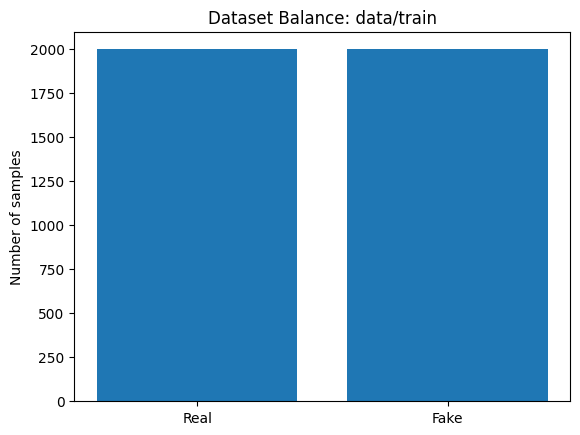


Dataset balance in data/dev:
Real samples: 1000 (50.0%)
Fake samples: 1000 (50.0%)


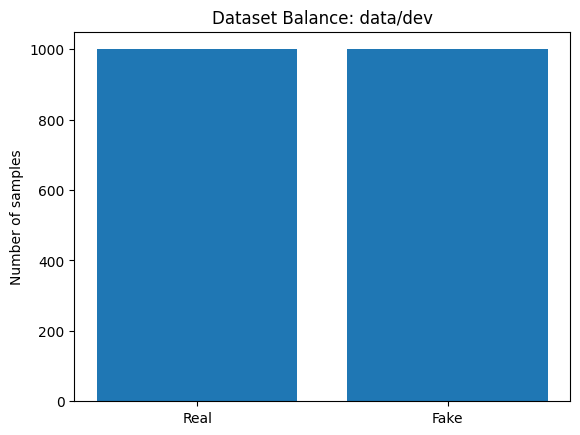

In [50]:
# ## Step 4: Verify Final Dataset Balance

# %% [code]
def check_dataset_balance(data_dir):
    real = len(os.listdir(f"{data_dir}/real"))
    fake = len(os.listdir(f"{data_dir}/fake"))
    total = real + fake

    print(f"\nDataset balance in {data_dir}:")
    print(f"Real samples: {real} ({real/total:.1%})")
    print(f"Fake samples: {fake} ({fake/total:.1%})")

    # Plot balance
    import matplotlib.pyplot as plt
    plt.bar(['Real', 'Fake'], [real, fake])
    plt.title(f"Dataset Balance: {data_dir}")
    plt.ylabel("Number of samples")
    plt.show()

check_dataset_balance("data/train")
check_dataset_balance("data/dev")


In [18]:
# ## Step 5: Audio Preprocessing (FLAC → MFCC)

# %% [code]
def extract_mfcc(audio_path, n_mfcc=40, sr=16000, max_len=16000):
    try:
        audio, sr = librosa.load(audio_path, sr=sr, mono=True)
        if len(audio) > max_len:
            audio = audio[:max_len]
        else:
            audio = np.pad(audio, (0, max_len - len(audio)))
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        return mfccs.T.astype(np.float16)
    except Exception as e:
        print(f"Error processing {audio_path}: {str(e)}")
        return None

def process_dir(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for file in tqdm(os.listdir(input_dir), desc=f"Processing {input_dir}"):
        input_path = os.path.join(input_dir, file)
        output_path = os.path.join(output_dir, file.replace(".flac", ".npy"))

        # Skip if already processed
        if os.path.exists(output_path):
            continue

        mfccs = extract_mfcc(input_path)
        if mfccs is not None:
            np.save(output_path, mfccs)

# Process all data
process_dir("data/train/real", "processed/train/real")
process_dir("data/train/fake", "processed/train/fake")
process_dir("data/dev/real", "processed/dev/real")
process_dir("data/dev/fake", "processed/dev/fake")


Processing data/dev/fake: 100%|██████████| 2000/2000 [00:07<00:00, 269.66it/s]


In [19]:
# Clean up raw files to save space
!rm -rf data/ extracted/

In [20]:
# ## Step 6: Define PyTorch Dataset and Model

# %% [code]
class AudioDataset(Dataset):
    def __init__(self, real_dir, fake_dir):
        self.real_files = [os.path.join(real_dir, f) for f in os.listdir(real_dir)]
        self.fake_files = [os.path.join(fake_dir, f) for f in os.listdir(fake_dir)]
        self.all_files = self.real_files + self.fake_files
        self.labels = [0] * len(self.real_files) + [1] * len(self.fake_files)

    def __len__(self):
        return len(self.all_files)

    def __getitem__(self, idx):
        mfccs = np.load(self.all_files[idx])
        return torch.FloatTensor(mfccs), torch.tensor(self.labels[idx], dtype=torch.long)

class MFCC_CNN(nn.Module):
    def __init__(self, n_mfcc=40, time_steps=100):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv1d(n_mfcc, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Flatten()
        )
        self.fc = nn.Linear(64 * (time_steps // 4), 2)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (Batch, Time, MFCC) → (Batch, MFCC, Time)
        return self.conv_layers(x)

In [28]:
# %% [markdown]
# ## Step 7: Model Training (Fixed for 32-timestep MFCCs)

# %% [code]
class FixedShortMFCC_CNN(nn.Module):
    def __init__(self, n_mfcc=40, time_steps=32):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv1d(n_mfcc, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),  # 32 -> 16

            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),  # 16 -> 8
        )
        self.flattened_dim = 128 * (time_steps // 4)  # 128 * 8 = 1024
        self.classifier = nn.Sequential(
            nn.Linear(self.flattened_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)  # [batch, 40, 32]
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# Initialize
model = FixedShortMFCC_CNN().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Training Loop
best_acc = 0
for epoch in range(20):
    model.train()
    train_loss = 0

    for mfccs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        mfccs, labels = mfccs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(mfccs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for mfccs, labels in dev_loader:
            mfccs, labels = mfccs.to(device), labels.to(device)
            outputs = model(mfccs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    print(f"Epoch {epoch+1}: "
          f"Train Loss: {train_loss/len(train_loader):.4f} | "
          f"Val Acc: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "models/best_model.pth")

Epoch 1: 100%|██████████| 276/276 [00:03<00:00, 80.13it/s]


Epoch 1: Train Loss: 0.2846 | Val Acc: 53.10%


Epoch 2: 100%|██████████| 276/276 [00:02<00:00, 120.96it/s]


Epoch 2: Train Loss: 0.1854 | Val Acc: 55.02%


Epoch 3: 100%|██████████| 276/276 [00:02<00:00, 123.55it/s]


Epoch 3: Train Loss: 0.1508 | Val Acc: 53.00%


Epoch 4: 100%|██████████| 276/276 [00:02<00:00, 124.50it/s]


Epoch 4: Train Loss: 0.1164 | Val Acc: 56.58%


Epoch 5: 100%|██████████| 276/276 [00:02<00:00, 123.23it/s]


Epoch 5: Train Loss: 0.0944 | Val Acc: 53.35%


Epoch 6: 100%|██████████| 276/276 [00:02<00:00, 124.33it/s]


Epoch 6: Train Loss: 0.0899 | Val Acc: 57.67%


Epoch 7: 100%|██████████| 276/276 [00:02<00:00, 123.41it/s]


Epoch 7: Train Loss: 0.0870 | Val Acc: 58.90%


Epoch 8: 100%|██████████| 276/276 [00:02<00:00, 124.38it/s]


Epoch 8: Train Loss: 0.0664 | Val Acc: 59.52%


Epoch 9: 100%|██████████| 276/276 [00:02<00:00, 124.86it/s]


Epoch 9: Train Loss: 0.0643 | Val Acc: 58.40%


Epoch 10: 100%|██████████| 276/276 [00:02<00:00, 124.68it/s]


Epoch 10: Train Loss: 0.0742 | Val Acc: 60.80%


Epoch 11: 100%|██████████| 276/276 [00:02<00:00, 123.30it/s]


Epoch 11: Train Loss: 0.1014 | Val Acc: 56.12%


Epoch 12: 100%|██████████| 276/276 [00:02<00:00, 125.24it/s]


Epoch 12: Train Loss: 0.0566 | Val Acc: 57.08%


Epoch 13: 100%|██████████| 276/276 [00:02<00:00, 123.99it/s]


Epoch 13: Train Loss: 0.0497 | Val Acc: 59.40%


Epoch 14: 100%|██████████| 276/276 [00:02<00:00, 122.82it/s]


Epoch 14: Train Loss: 0.0407 | Val Acc: 57.15%


Epoch 15: 100%|██████████| 276/276 [00:02<00:00, 123.07it/s]


Epoch 15: Train Loss: 0.0481 | Val Acc: 58.80%


Epoch 16: 100%|██████████| 276/276 [00:02<00:00, 118.04it/s]


Epoch 16: Train Loss: 0.0833 | Val Acc: 57.52%


Epoch 17: 100%|██████████| 276/276 [00:02<00:00, 120.56it/s]


Epoch 17: Train Loss: 0.0714 | Val Acc: 57.17%


Epoch 18: 100%|██████████| 276/276 [00:02<00:00, 106.36it/s]


Epoch 18: Train Loss: 0.0418 | Val Acc: 58.15%


Epoch 19: 100%|██████████| 276/276 [00:02<00:00, 121.96it/s]


Epoch 19: Train Loss: 0.0342 | Val Acc: 55.30%


Epoch 20: 100%|██████████| 276/276 [00:02<00:00, 123.16it/s]


Epoch 20: Train Loss: 0.0244 | Val Acc: 58.52%


In [26]:
    # ## Cleanup (Optional)
# Uncomment to free up space after training:

# %% [code]
# !rm -rf raw_data/ protocols/